# Determining corrections to the number of positives

The number of daily positives $P_i$, has to be scaled in relation to the number of daily tests $T_i$ as $(T_i/\bar{T})^{-\gamma}$, as the number of positives does not grow linearly with number of tests.
Furthermore, variation with weekday remains, which should be subsequently corrected for.

The following code determins from the (PCR) test data:
- Measuring the scaling exponent of positives with respect to number of tests
- Determining further weekday corrections

Thus, the below code measures this exponent, as the current value of $\gamma = 0.7$ was determined several months ago (by Uffe from SSI), and may have changed. Also a measurement of this value for the AntiGen test is in order. The estimates should be done for both the entire period (e.g. 1st of September 2020 - 1st of March 2021) and possibly also monthly to test, if there are significant variations.

The analysis is related to the observation, that the fraction of positives usually increases on Mondays (i.e. results from the weekend). However, one should **first** determine $\gamma$, and if any weekly variations remain, these should be accounted for **subsequently**.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import scipy 
import datetime as dt
# from scipy.optimize import curve_fit, minimize
import scipy.stats
from scipy import stats
import iminuit
from iminuit import Minuit
from scipy.optimize import curve_fit
import os

mpl.rcParams['font.size'] = 18      # Set the general plotting font size
plt.rc("font", family="serif")
#plt.rc("text", usetex=True)

### General settings:

In [2]:
save_plots = True

day_0 = '2020-12-14'
fit_to_today = False
gamma_period = ['2020-12-14', '2021-03-08']

date_start = '2020-12-14'
date_end   = '2021-02-28'

***

# Fit to current test & positive numbers:

## Read the data:

Here the input should be a text file with the rows from the .pdf copied in with the last day first. See the provided .txt file for an example.

In [3]:
#data = pd.read_csv("../PrivateData/PrivateData090321.csv", sep=',', index_col=0)
filepath = "../PrivateData/PrivateData090321.txt" #In a seperate folder for now, subject to change

with open(filepath, 'r') as data: #Pretty messy code, could be changed with better inputs
    lines = data.readlines()
    n = len(lines)
    Np_AG = np.zeros(n)
    Nt_AG = np.zeros(n)
    Np_PCR = np.zeros(n)
    Nt_PCR = np.zeros(n)
    days = np.zeros(n, dtype=object)
    for index, line in enumerate(lines):
        x = line.split()
        days[index] = x[0].replace('.','-') #Changing separators
        days[index] = days[index][6:] + '-' + days[index][3:5] + '-' + days[index][:2] #Converting into right format
        Nt_AG[index] = float(x[5].replace('.',''))#Removing separators if they exist
        Np_AG[index] = float(x[6].replace('.',''))
        Nt_PCR[index] = float(x[2].replace('.',''))
        Np_PCR[index] = float(x[3].replace('.',''))

all_data = pd.DataFrame(np.array([days, Nt_AG, Np_AG, Nt_PCR, Np_PCR]).T, columns=['Day', 'Nt_AG', 'Np_AG', 'Nt_PCR', 'Np_PCR'])
#Have to assert this or some calculations do not work
all_data = all_data.astype({'Day': 'datetime64', 'Nt_AG': 'int64', 'Nt_PCR': 'int64', 'Np_AG': 'int64', 'Np_PCR': 'int64'}) 
all_data = all_data.set_index('Day')


# All of Denmark
if fit_to_today:
    date_end = data_test.index[-1]
    
P_AG = np.flip(all_data["Np_AG"][date_end:date_start])
eP_AG = np.sqrt(P_AG)
N_AG = np.flip(all_data["Nt_AG"][date_end:date_start])
eN_AG = np.sqrt(N_AG)
P_PCR = np.flip(all_data["Np_PCR"][date_end:date_start])
eP_PCR = np.sqrt(P_PCR)
N_PCR = np.flip(all_data["Nt_PCR"][date_end:date_start])
eN_PCR = np.sqrt(N_PCR)
day  = np.arange(1,len(P_AG)+1)

# Number of positive tests and uncertainty, assuming fixed number of daily tests and power law correction:
Power = 0.56         # Power in power law for the increase in positives with increase in tests.
# SystError = 0.000   # To account for larger uncertainties on fraction positives than simply the statistical.

# TP 6. March: Are the above necessary? And the below scaling (yet)?
# TP 8. March: Better naming of....  P -> SP -> SCP

nAveDailyTests_AG = N_AG.mean()
nAveDailyTests_PCR = N_PCR.mean()
print("Average number of AntiGen tests: ", nAveDailyTests_AG)
print("Average number of PCR tests: ", nAveDailyTests_PCR)
fPos_AG = P_AG / N_AG
nPos_AG  = P_AG * (N_AG / nAveDailyTests_AG)**(-Power)
enPos_AG = (N_AG*fPos_AG*(1-fPos_AG) ) ** 0.5 * (N_AG / nAveDailyTests_AG)**(-Power)
fPos_PCR = P_PCR / N_PCR
nPos_PCR  = P_PCR * (N_PCR / nAveDailyTests_PCR)**(-Power)
enPos_PCR = (N_PCR*fPos_PCR*(1-fPos_PCR) ) ** 0.5 * (N_PCR / nAveDailyTests_PCR)**(-Power)

all_data.dtypes

Average number of AntiGen tests:  28503.012987012986
Average number of PCR tests:  1133.5974025974026


Nt_AG     int64
Np_AG     int64
Nt_PCR    int64
Np_PCR    int64
dtype: object

## Define ranges, fitting function, and model:

In [4]:
Plot_StartDay = 1
Plot_EndDay   = 63

Fit_StartDay  = 0
Fit_EndDay    = 33
day1jan       = np.arange(Plot_StartDay, Plot_EndDay)
day1jan_fit   = np.arange(Fit_StartDay, Fit_EndDay)
Npoints = len(day1jan_fit)

day_extrapol = 20


### Comparison of geometric mean with scaled positives
First we define a likelihood for comparingf geometric mean of scaled positives and scaled positives with variable scaling, $\gamma$. Then best fit and uncertainty on gamma within time-period is defined

In [43]:
def model_bllh_og(N_obs, N_exp):
    p_cdf = np.zeros_like(N_exp)
    p_cdf[N_obs < N_exp]  = scipy.stats.poisson.logcdf( N_obs[N_obs < N_exp], N_exp[N_obs < N_exp] )
    p_cdf[N_obs >= N_exp] = scipy.stats.poisson.logsf(  N_obs[N_obs >= N_exp], N_exp[N_obs >= N_exp] )
    return - 2 * sum( (p_cdf) )

def model_bllh(N_obs, N_exp):
    p_cdf = np.zeros_like(N_exp)
    p_cdf  = scipy.stats.poisson.logcdf( N_obs, N_exp )
    p_cdf[p_cdf >= np.log(0.5)] = scipy.stats.poisson.logsf(  N_obs[p_cdf >= np.log(0.5)], N_exp[p_cdf >= np.log(0.5)] )
    return - 2 * sum( (p_cdf) )

#Find likelihood of N_obs given N_exp with poisson statistics

def gamma_index(P, N, AveDaily, PCR=False): #finds best fit gamma and uncertainty for period
    llh_list = []
    if PCR:
        print("PCR")
    else:
        print("AntiGen")
    gamma_list = np.linspace(0,1.,101) #probe gamma in discrete values. 
    for gamma in gamma_list:
        nPos_all  = P * (N / AveDaily)**(-gamma)
        enPos_all = np.sqrt(P * (N / AveDaily)**(-gamma))
    
        y = nPos_all[Plot_StartDay:Plot_EndDay]
        y_exp = []
        for i in range(3,len(y)-3):
            if PCR:
                y_exp.append(np.mean(y[i-3:i+4]))#Arithmetic mean for PCR tests
            else:
                y_exp.append( (np.prod(y[i-3:i+4]))**(1/7) )
            #Geometric running average, predicted scaled positive test number
            #Problems here with PCR as there are sometimes zero positive tests which results in errors further along
        llh = model_bllh( np.array(nPos_all[Plot_StartDay+4:Plot_EndDay-2].values), np.array(y_exp) )
        llh_list.append(llh)     
    min_llh = min(llh_list)
    
    fig,ax=plt.subplots(figsize=(12,6)) #Plot to see if quadratic approximation is good
    ax.plot(gamma_list[np.isclose(llh_list, min_llh, atol=10.)], 
               np.array(llh_list)[np.isclose(llh_list, min_llh, atol=10.)])
    ax.set(xlabel=r"$\gamma$", ylabel="-2*log likelihood")
    plt.show()
    p = np.polyfit(gamma_list[np.isclose(llh_list, min_llh, atol=10.)], 
               np.array(llh_list)[np.isclose(llh_list, min_llh, atol=10.)], 2)
    gamma = -p[1]/(2*p[0])
    dgamma = 1/np.sqrt(p[0]) #fit parabola fit intercept with 1 sigma 
    #Fails for some gamma due to the first element being negative
    
    return gamma, dgamma, llh_list, gamma_list, nPos_all, enPos_all, y_exp

#gamma, dgamma, llh_list, gamma_list, nPos_all, enPos_all, y_exp = gamma_index()

### Compare $\gamma (t)$

Compute $\gamma (t)$ as a linear function using locally computed geometric mean or arithmetic mean for PCR

AntiGen


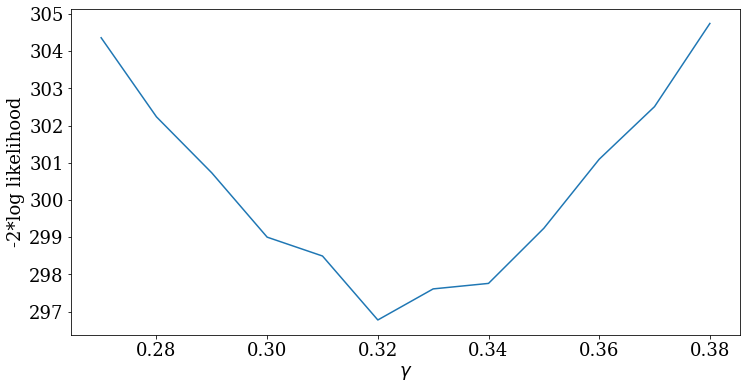

PCR


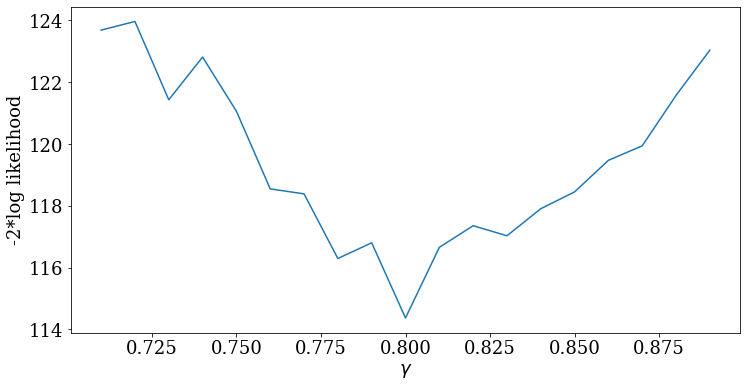

AntiGen


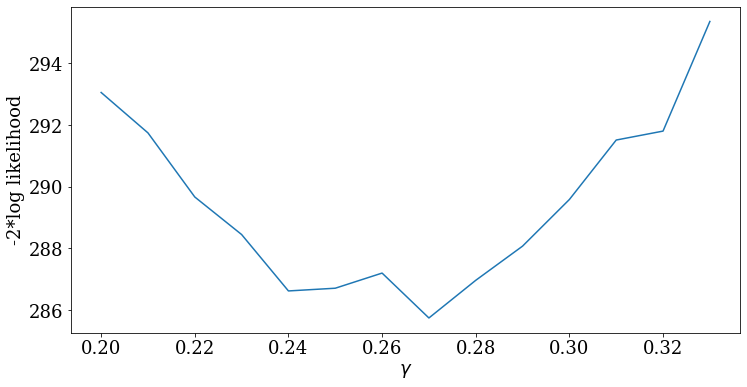

PCR


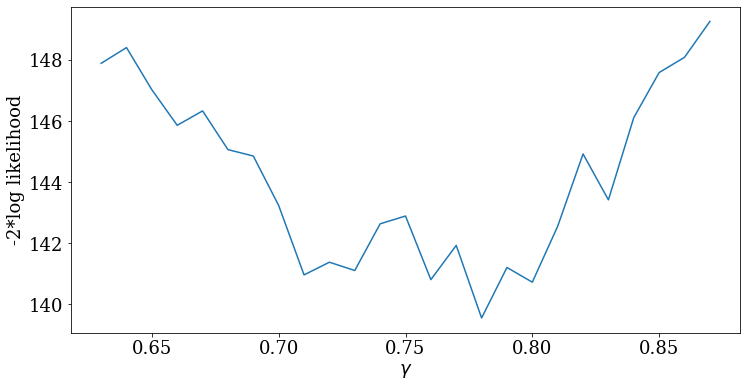

AntiGen


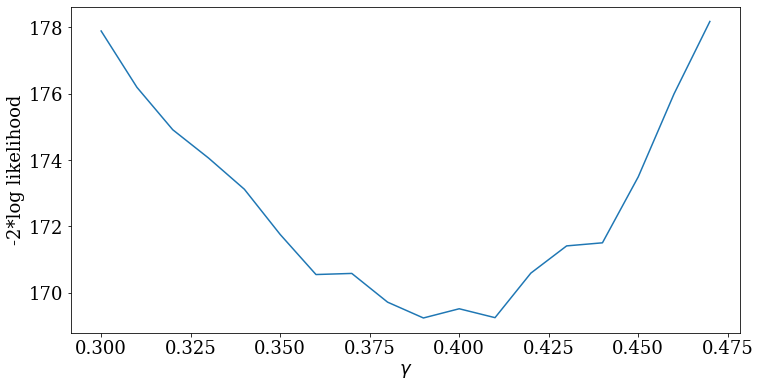

PCR


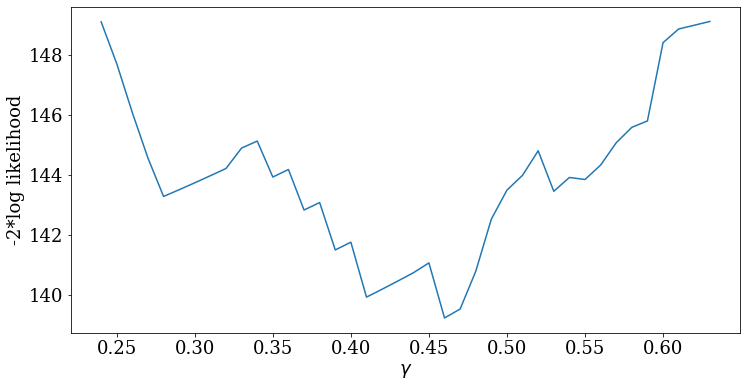

AntiGen


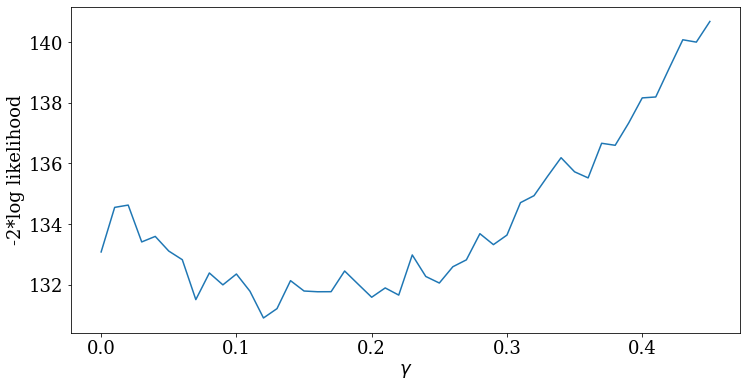

PCR


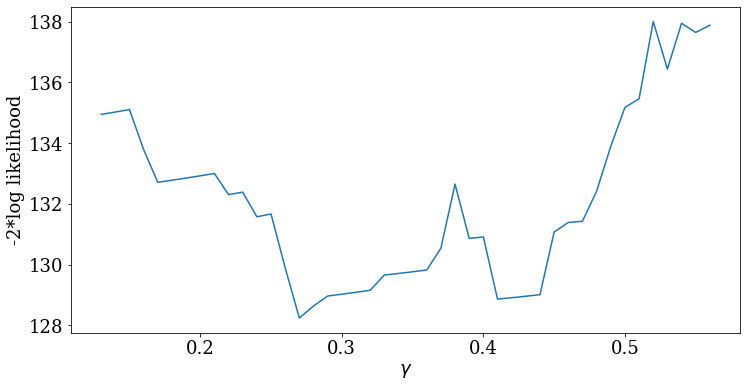

AntiGen


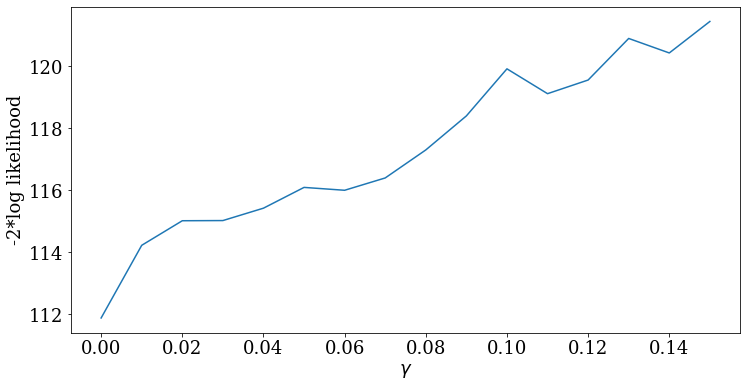

PCR


<ipython-input-43-6a74bc74405a>:47: RuntimeWarning: invalid value encountered in sqrt
  dgamma = 1/np.sqrt(p[0]) #fit parabola fit intercept with 1 sigma


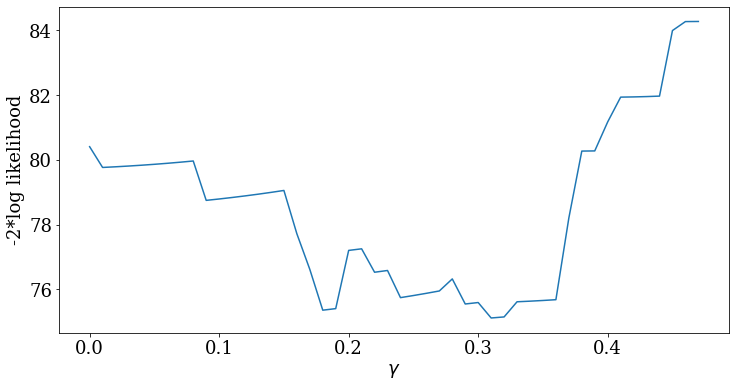

AntiGen


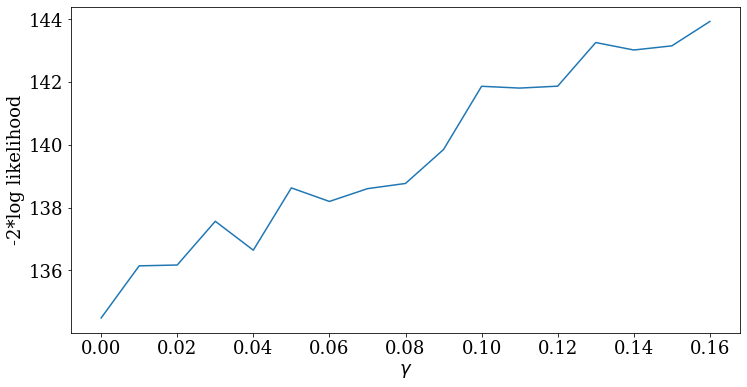

PCR


<ipython-input-43-6a74bc74405a>:47: RuntimeWarning: invalid value encountered in sqrt
  dgamma = 1/np.sqrt(p[0]) #fit parabola fit intercept with 1 sigma


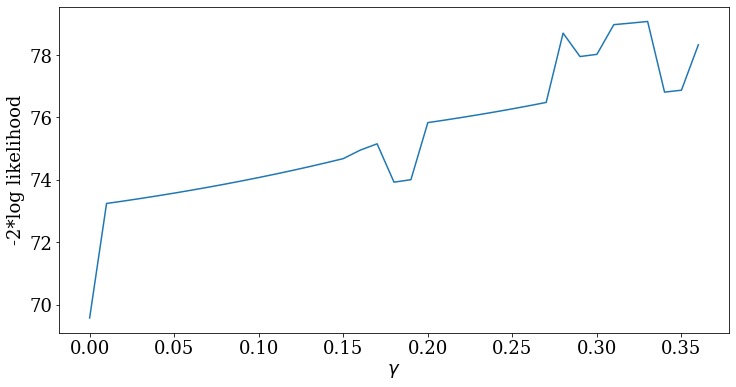

AntiGen


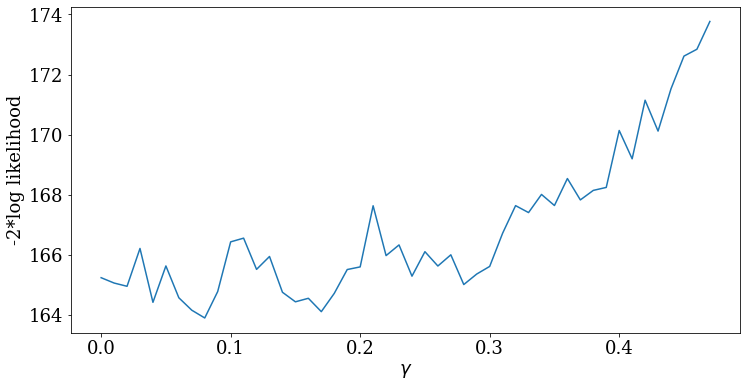

PCR


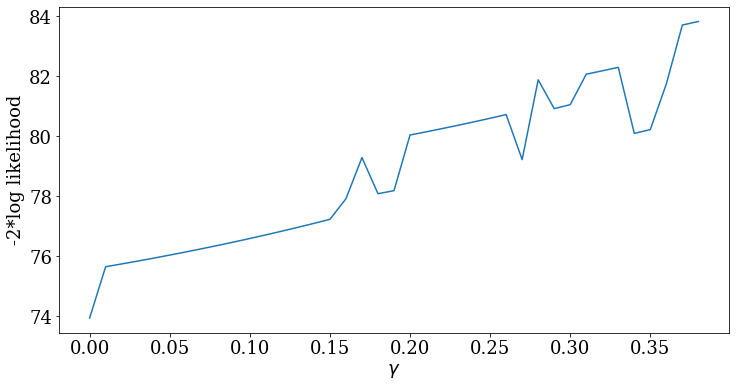

<ipython-input-43-6a74bc74405a>:47: RuntimeWarning: invalid value encountered in sqrt
  dgamma = 1/np.sqrt(p[0]) #fit parabola fit intercept with 1 sigma


In [44]:
gamma_t_AG = []
dgamma_t_AG = []
gamma_t_PCR = []
dgamma_t_PCR = []


days_between_points = 7
for i in np.arange(0,len(all_data["Np_AG"][date_end:date_start])-28,days_between_points): 
    P_AG = np.flip(all_data["Np_AG"][date_end:date_start])
    eP_AG = np.sqrt(P_AG)
    N_AG = np.flip(all_data["Nt_AG"][date_end:date_start])
    eN_AG = np.sqrt(N_AG)
    P_PCR = np.flip(all_data["Np_PCR"][date_end:date_start])
    eP_PCR = np.sqrt(P_PCR)
    N_PCR = np.flip(all_data["Nt_PCR"][date_end:date_start])
    eN_PCR = np.sqrt(N_PCR)
    day  = np.arange(1,len(P_AG)+1)
    
    Plot_StartDay = i
    Plot_EndDay   = 28+i

    nAveDailyTests_AG = N_AG.mean()
    nAveDailyTests_PCR = N_PCR.mean()
    
    fPos_PCR = P_PCR / N_PCR
    fPos_AG = P_AG / N_AG
    gamma_AG, dgamma_AG, llh_list_AG, gamma_list_AG, nPos_all_AG, enPos_all_AG, y_exp_AG = gamma_index(P_AG, N_AG, nAveDailyTests_AG)
    gamma_t_AG.append(gamma_AG), dgamma_t_AG.append(dgamma_AG)
    gamma_PCR, dgamma_PCR, llh_list_PCR, gamma_list_PCR, nPos_all_PCR, enPos_all_PCR, y_exp_PCR = gamma_index(P_PCR, N_PCR, nAveDailyTests_PCR,PCR=True)
    gamma_t_PCR.append(gamma_PCR), dgamma_t_PCR.append(dgamma_PCR) 

Here we plot $\gamma(t)$ for AntiGen

[0.02046222 0.02331    0.02935723 0.09726565 0.2        0.2
 0.12312525]
[ 0  7 14 21 28 35 42]


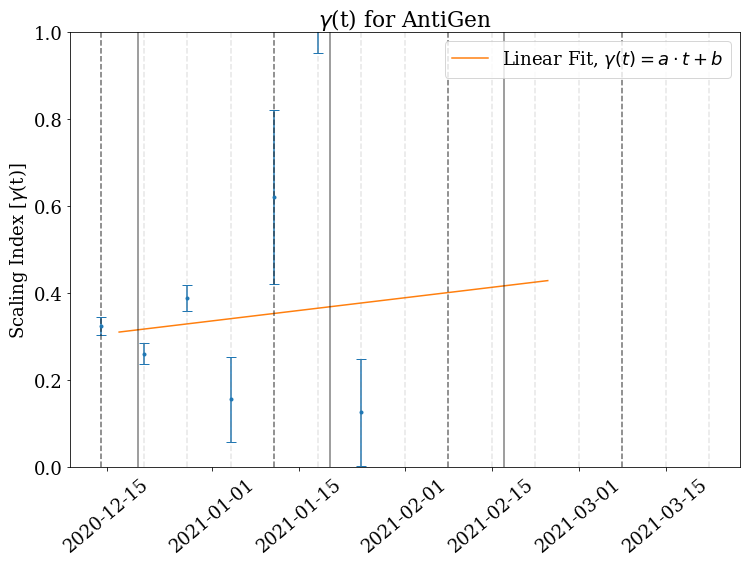

In [25]:
#Testing due to NaNs in errors on gamma
dgamma_t_AG = np.nan_to_num(dgamma_t_AG,nan=0.2) #Replace NaN by some number

print(dgamma_t_AG)

days = days_between_points*np.arange(len(gamma_t_AG)) 
now = dt.date(year=int(date_start[:4]), month = int(date_start[5:7]), day = int( date_start[8:]))
print(days)

dates = []
for x in np.arange(len(gamma_t_AG)):
    dates.append(now + dt.timedelta(days=int(days_between_points*x)))

plt.figure(figsize=(12,8))
plt.errorbar(dates, gamma_t_AG, yerr=dgamma_t_AG, fmt='.', capsize=5)
plt.ylabel(r'Scaling Index [$\gamma$(t)]')#, plt.xlabel('Days from '+date_start)
plt.ylim(0,1)#, plt.legend() 
plt.title("$\gamma$(t) for AntiGen")



#fit linear function
def lin(x,a,b):
    return a*x+b
p, cov = curve_fit(lin, days, gamma_t_AG, sigma=dgamma_t_AG)
power = lin(np.arange(3,len(P_AG[date_start:date_end])-4), *p)

#Heavyside
#power = []
#for idx,i in enumerate(Ntest_all[date_start:date_end][3:-4].index):
#    if idx < 90:
#        power.append(0.78)
#    else:
#        power.append(0.57)
plt.plot(N_AG[date_start:date_end][3:-4].index, power, label=f'Linear Fit, $\gamma (t) = a \cdot t + b$')        

#This creates weekly lines


for x in np.arange(0,100,7): #weeks
    plt.axvline( now + dt.timedelta(days=int(x)), ls='--', color='grey', alpha=0.2)
for x in np.arange(0,100,28): #month 
    plt.axvline( now + dt.timedelta(days=int(x)), ls='--', color='k', alpha=0.5)
    
# Plot monthly lines on first date
d_now = dt.date(year=int(date_start[:4]), month = int(date_start[5:7]), day = int( date_start[8:] ))
for i in range(len(P_AG)):
    d_now = d_now + dt.timedelta(days=1)
    if d_now.day == 1:
        plt.axvline( d_now-dt.timedelta(days=12), ls='-', color='k', alpha=0.5)
    
times = []; N_weeks = int(len(P_AG)/14)
for i in range(N_weeks):
    times.append(d_now + dt.timedelta(days=14*i))
    
#plt.xticks(ticks=[14*i for i in range(N_weeks)], 
#          labels=[str(time.year)+'-'+str(time.month)+'-'+str(time.day) for time in times], rotation=30 );
plt.legend(loc='best')
plt.xticks(rotation = 40)
plt.savefig('gamma_t_2.png', dpi=300)

Here we plot $\gamma(t)$ for PCR

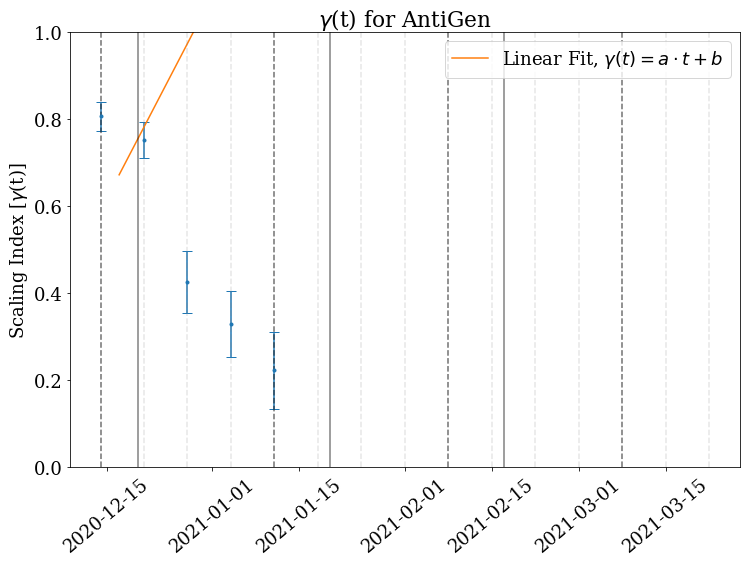

In [28]:
days = days_between_points*np.arange(len(gamma_t_PCR)) 
now = dt.date(year=int(date_start[:4]), month = int(date_start[5:7]), day = int( date_start[8:]))

dates = []
for x in np.arange(len(gamma_t_PCR)):
    dates.append(now + dt.timedelta(days=int(days_between_points*x)))

plt.figure(figsize=(12,8))
plt.errorbar(dates, gamma_t_PCR, yerr=dgamma_t_PCR, fmt='.', capsize=5)
plt.ylabel(r'Scaling Index [$\gamma$(t)]')#, plt.xlabel('Days from '+date_start)
plt.ylim(0,1)#, plt.legend() 
plt.title("$\gamma$(t) for AntiGen")

#Testing due to NaNs in errors in gamma
dgamma_t_PCR = np.nan_to_num(dgamma_t_AG,nan=0.5) #Replace NaN by some number


#fit linear function
def lin(x,a,b):
    return a*x+b
p, cov = curve_fit(lin, days, gamma_t_PCR, sigma=dgamma_t_PCR)
power = lin(np.arange(3,len(P_PCR[date_start:date_end])-4), *p)

#Heavyside
#power = []
#for idx,i in enumerate(Ntest_all[date_start:date_end][3:-4].index):
#    if idx < 90:
#        power.append(0.78)
#    else:
#        power.append(0.57)
plt.plot(N_PCR[date_start:date_end][3:-4].index, power, label=f'Linear Fit, $\gamma (t) = a \cdot t + b$')        

#This creates weekly lines


for x in np.arange(0,100,7): #weeks
    plt.axvline( now + dt.timedelta(days=int(x)), ls='--', color='grey', alpha=0.2)
for x in np.arange(0,100,28): #month 
    plt.axvline( now + dt.timedelta(days=int(x)), ls='--', color='k', alpha=0.5)
    
# Plot monthly lines on first date
d_now = dt.date(year=int(date_start[:4]), month = int(date_start[5:7]), day = int( date_start[8:] ))
for i in range(len(P_PCR)):
    d_now = d_now + dt.timedelta(days=1)
    if d_now.day == 1:
        plt.axvline( d_now-dt.timedelta(days=12), ls='-', color='k', alpha=0.5)
    
times = []; N_weeks = int(len(P_PCR)/14)
for i in range(N_weeks):
    times.append(d_now + dt.timedelta(days=14*i))
    
#plt.xticks(ticks=[14*i for i in range(N_weeks)], 
#          labels=[str(time.year)+'-'+str(time.month)+'-'+str(time.day) for time in times], rotation=30 );
plt.legend(loc='best')
plt.xticks(rotation = 40)
plt.savefig('gamma_t_2.png', dpi=300)

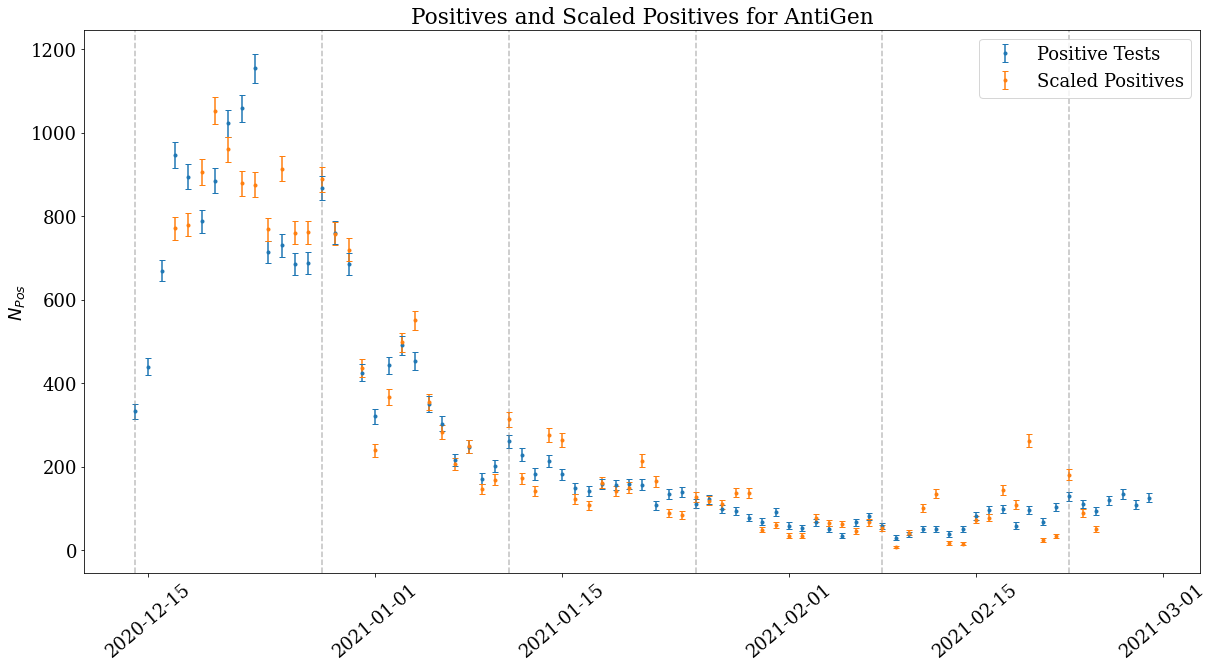

In [9]:
plt.figure(figsize=(20,10))
plt.errorbar(P_AG.index, P_AG[date_start:date_end], 
             yerr = eP_AG[date_start:date_end], fmt='.', capsize=3, label='Positive Tests')
plt.title("Positives and Scaled Positives for AntiGen")

now = dt.date(year=int(date_start[:4]), month = int(date_start[5:7]), day = int( date_start[8:]))

#includes date on x-label
ax = plt.gca()
temp = ax.xaxis.get_ticklabels()
temp = list(set(temp) - set(temp[::14]))
#for label in temp:
#    label.set_visible(False)
for x in np.arange(0,len(P_AG[date_start:date_end]),14): #weeks
    plt.axvline(now + dt.timedelta(days=int(x)), ls='--', color='grey', alpha=0.5)
    
mean_arr = []
for i in np.arange(3,len(P_AG[date_start:date_end])-4): 
    mean_arr.append( np.mean(N_AG[date_start:date_end][i-3:i+4]) )
SP = P_AG[3:-4] * (N_AG[date_start:date_end][3:-4]/mean_arr)**(-np.asarray(power) )


plt.errorbar(SP.index, SP[date_start:date_end], 
             yerr = np.sqrt(SP[date_start:date_end]), fmt='.', capsize=3, label='Scaled Positives')
plt.ylabel(r'$N_{Pos} $')
plt.xticks(rotation = 40); plt.legend();

plt.savefig('Scaled_pos.png', dpi=300)




Given $\gamma (t)$ compute the locally scaled positive test rate and plot residuals.
Week_coor compares scaled positive to total positives to show weekly bias. 

In [10]:
def fractional_dev(mean, spread, date_start, dato_end):
    roll = dt.date(int(date_start[:4]), int(date_start[5:7]), int(date_start[8:]) ).weekday() + 3   
    
    plt.figure(figsize=(10, 7))
    plt.errorbar(np.arange(len(mean)), np.roll(mean, roll), yerr=np.roll(spread,roll), 
                 fmt='.', capsize=10,  color='b', label=date_start+' to '+dato_end)
    #plt.errorbar(np.arange(len(mean)), mean, yerr=spread, fmt='.', capsize=10,  color='r')
    
    plt.legend()
    plt.ylabel('Fractional Deviation')
    plt.axhline(0, ls='--', color='k')
    plt.xticks([0,1,2,3,4,5,6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], rotation=25);
    
#plt.savefig('Weekly_Oscilation.png', dpi=300)

In [11]:
# fractional_dev(mean, spread, "2020-09-01", date_end)

# plt.savefig('Fractional_deviation_wo_gamma.png', dpi=300)

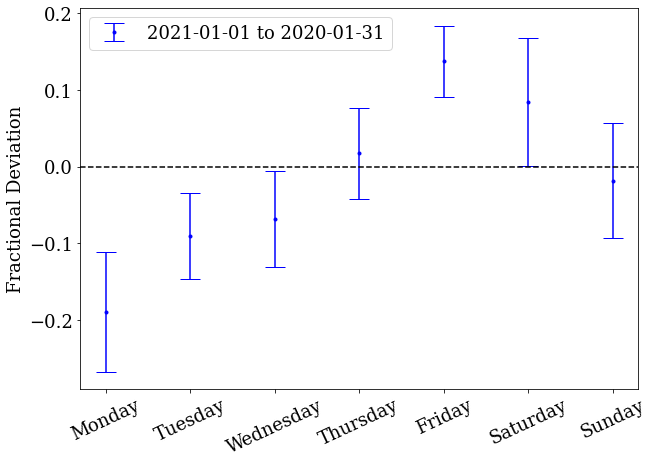

In [12]:
def week_corr_sp_sys_AG(dato_start = "2021-01-01", dato_end   = "2020-01-31", power=0.56):
    P_AG = np.flip(all_data["Np_AG"][date_end:date_start])
    eP_AG = np.sqrt(P_AG)
    N_AG = np.flip(all_data["Nt_AG"][date_end:date_start])
    eN_AG = np.sqrt(N_AG)
    mean_arr = []
    
    # Calculate mean of tested in week:
    for i in np.arange(3,len(P_AG)-4): 
        mean_arr.append( np.mean(N_AG[i-3:i+4]) )
    
    # Scale Positive tested in week:
    SP = P_AG[3:-4] * (N_AG[3:-4]/mean_arr)**(-power)
    SP_exp = np.zeros_like(SP)
    
    # Geometric mean of the Scaled Positives:
    for i in np.arange(3,len(SP)-4): 
        SP_exp[i] = (np.prod(SP[i-3:i+4]))**(1/7)
    
    # Fractional correction by weekday:
    n_days = (len(np.arange(3,len(SP_exp)-4)) % 7)
    nweeks = int((len(np.arange(3,len(SP_exp)-4))-n_days) / 7)
    if n_days == 0: 
        SP_week = np.reshape(SP_exp[3:-4], (nweeks, 7))
        Nposi_week = np.reshape(SP[3:-4].values, (nweeks, 7))
    else:
        SP_week = np.reshape(SP_exp[3:-4][:-(len(np.arange(3,len(SP)-4)) % 7)], (nweeks, 7))
        Nposi_week = np.reshape(SP[3:-4].values[:-(len(np.arange(3,len(SP)-4)) % 7)], (nweeks, 7))
        
    mean, spread = np.mean((SP_week-Nposi_week)/SP_week, axis=0), np.std((SP_week-Nposi_week)/SP_week, axis=0)/np.sqrt(nweeks-1)
    
    return mean, spread, SP, SP_exp, P_AG

mean1, spread1, SP, SP_exp, Nposi_all = week_corr_sp_sys_AG(dato_start = date_start, dato_end = date_end)

fractional_dev(mean1, spread1, "2021-01-01", "2020-01-31")
plt.savefig('Fractional_deviation_wo_gamma.png', dpi=300)

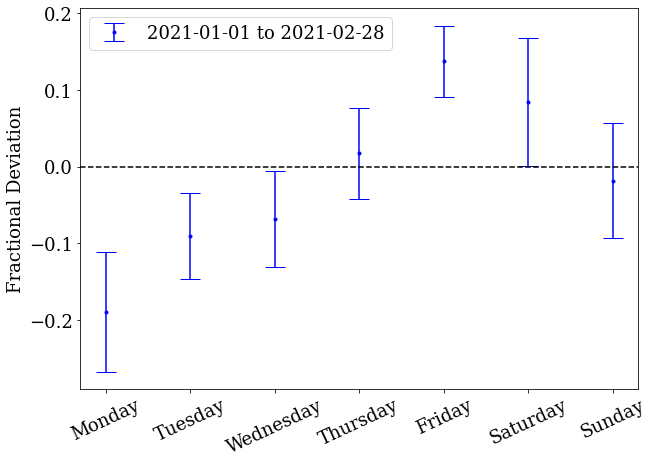

In [13]:
mean, spread, SP, SP_exp,Nposi_all = week_corr_sp_sys_AG(dato_start = '2021-01-01', dato_end   = date_end)

fractional_dev(mean, spread, "2021-01-01", date_end)

In [14]:
def week_correction_old(dato_start, dato_end, gamma, PCR=False):
    """
    dato_start, dato_end = start day and en day of period we will analyse. On the form 'year-month-date'.
                           Notice the corrections we will calculate will remove three days from each side
                           of this period to be able to compute the geometric mean
    gamma = the power for the given period. Constant.
    """
    
    # Extract data from the time period
    
    if PCR: #Use to change between looking at PCR or AntiGen, has consequences for the means later 
        P_all = np.flip(all_data["Np_PCR"][date_end:date_start])
        eP_all = np.sqrt(P_PCR)
        T_all = np.flip(all_data["Nt_PCR"][date_end:date_start])
        eT_all = np.sqrt(N_PCR)
    else:    
        P_all = np.flip(all_data["Np_AG"][date_end:date_start])
        eP_all = np.sqrt(P_AG)
        T_all = np.flip(all_data["Nt_AG"][date_end:date_start])
        eT_all = np.sqrt(N_AG)
    
    T_mean = T_all.mean()
    
    # Find mean of tests performed, to use as T in the formula to find scaled positives SP
    # The mean is found by looking at three days on each side
        #mean_arr = []
        #for i in np.arange(3, len(P_all)-4): 
        #mean_arr.append( np.mean(T_all[i-3:i+4]) )
    
    # Find observed scaled positives
    SP_obs = P_all * (T_all/T_mean)**(-gamma)
    
    # Find expected scaled positives as the geometric mean of three days on each side
    SP_exp = np.zeros_like(SP_obs[6:]) #remove the six days on each day we dont use
    eSP_exp = np.zeros_like(SP_obs[6:])
    
    n = 7 #number of days we compute the mean from = 2*3+1

    if PCR:
        for i in np.arange(3,len(SP_obs)-3): 
        
            # Arithmetic Mean
            SP_exp[i-3] = np.mean(SP_obs[i-3:i+4]) 
        
            # Error on the mean
            eSP_exp[i-3] = np.exp( np.sqrt( np.sum( np.log(SP_obs[i-3:i+4])**2/n ) ) )
    else:
        for i in np.arange(3,len(SP_obs)-3): 
        
            # Geometric mean
            SP_exp[i-3] = (np.prod(SP_obs[i-3:i+4]))**(1/n) 
        
            # Error on geometric mean - from https://en.wikipedia.org/wiki/Geometric_standard_deviation
            eSP_exp[i-3] = np.std(SP_obs[i-3:i+4], ddof=1)/np.sqrt(n)
    
    # Fractional corrections --------------------------------------------------------------
    
    # Find number of weeks (rows in our matrix of size (weeks,7) ): +1 to make sure we have enough
    nrows = len(SP_exp) // 7 + 1

    # Create two arrays with nan, so elements not filled in will not contribute to the weighted average
    SP_obs_arr = np.empty(nrows * 7)
    SP_obs_arr[:] = np.nan
    
    SP_exp_arr = np.empty(nrows * 7)
    SP_exp_arr[:] = np.nan
    
    # Find out which day of the week, the first element is (should be dato_start+3)
    first_weekday = dt.date(int(dato_start[:4]), int(dato_start[5:7]), int(dato_start[8:10])) + dt.timedelta(days=3)
    day_index = first_weekday.weekday() #this would be the index where to insert the first element
    
    # Fill in SP_obs and SP_exp into empty array so they will have the right shape, ie. if we start on a 
    # thursday the first 3 values will be np.nan    
    SP_obs_arr[day_index:day_index+len(SP_exp)] = SP_obs[3:-3]
    SP_exp_arr[day_index:day_index+len(SP_exp)] = SP_exp
    
    # Lets reshape the array into matrices of the form week x day
    SP_obs_mat = SP_obs_arr.reshape(nrows, 7)
    SP_exp_mat = SP_exp_arr.reshape(nrows, 7)
    
    # Lets display what we have gotten so far in a imshow plot, each column should be the same color ish
    # if not there are big deviations
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow( (SP_obs_mat - SP_exp_mat) / SP_exp_mat )
    fig.colorbar(im)
    
    # Find mean of the fractional correction for each weekday, ie along the axis 0 = rows
    mean = np.nanmean( (SP_obs_mat - SP_exp_mat) / SP_exp_mat , axis=0)   #monday, tuesday, wednesday etc.
    n_days = np.count_nonzero((~np.isnan(SP_obs_mat)), axis=0) #counts number of non nan elements in each column
    std = np.nanstd( (SP_obs_mat - SP_exp_mat) / SP_exp_mat , axis=0) / np.sqrt(n_days-1)
    
    return mean, std

(array([-0.12792604, -0.06821179,  0.04632352,  0.24260687,  0.08862816,
         0.06478772, -0.05237536]),
 array([0.04705718, 0.09815315, 0.06580287, 0.07244438, 0.05122303,
        0.05663457, 0.06322184]))

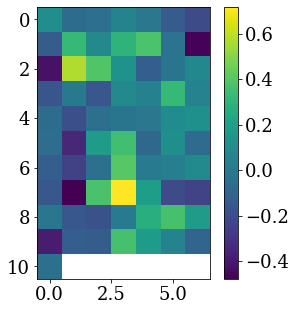

In [46]:
week_correction_old("2021-01-01", "2021-01-31",gamma=0.7448130551995493,PCR=False)
#Using gamma from Kimi for testing until errors in finding gamma for this dataset has been fixed 